this notebook does some spot checking on learned weight patterns in `scripts/training/imagenet_val/feature_approximation/local_pcn_original_imagenet/submit_sep2.py`.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/imagenet_val/feature_approximation/local_pcn_original_imagenet'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from sklearn.decomposition import PCA
from pickle import dump

In [7]:


def calc_raw_stats(weight_matrix):
    # weight_matrix is N * D
    # N = number of filters
    # D = size of a (flattened) filter.
    mean_all = weight_matrix.mean(axis=1)
    std_all = weight_matrix.std(axis=1)
    print('mean_all', mean_all.mean(), mean_all.std())
    print('std_all', std_all.mean(), std_all.std())
    
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def construct_back_by_interleave(x1, x2, by1, by2):
    n1, m1 = x1.shape
    n2, m2 = x2.shape
    assert n1 % by1 == 0
    assert n2 % by2 == 0
    assert m1==m2 and n1//by1 == n2//by2
    
    x1 = x1.reshape(n1//by1, by1, m1)
    x2 = x2.reshape(n2//by2, by2, m2)
    return np.concatenate((x1,x2), axis=1).reshape((n1+n2, m1))


def save_one_result(filename, data):
    makedirs(dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        dump(data, f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'scripts+imagenet_val+feature_approximation_lpcn_original_sep2',
                    'pca')
}

def prepare_dir():
    save_dir = global_vars['save_dir']
    if not exists(save_dir):
        makedirs(save_dir)
prepare_dir()

In [9]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    verbose = True
    for idx, data in enumerate(param_iterator()):
        count += 1        
        
        key = data['key_this_original']
#         if data['param_dict_actual']['basemodel_idx'] in (1,2):
#             # seems too much memory and jobs crashed on mind. not available.
#             continue
        
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
        # then load weights.
        result = load_training_results(key, return_model=False, return_checkpoint=True)
        # load loss curve to make sure we are good in approximation.
        
        
        loss_curves = sum([ [y['train'] for y in x] for x in result['stats_all']], [])
        print(len(loss_curves))
        
        # plot the curve
        plt.close('all')
        plt.figure(figsize=(10, 3))
        plt.plot(loss_curves)
        plt.show()
        
        # use float64 for all analysis to retain precision.
        weight_np = result['checkpoint']['model']['moduledict.conv0.weight'].numpy().astype(np.float64)
#         print(weight_np.dtype)
#         print(weight_np.shape)
#         channel_shape_all = (16, 32)
#         assert len(weight_np.shape)==4 and weight_np.shape[:2] == channel_shape_all
        
        kernel_shape = weight_np.shape[2:]
#         channel_shape = (16, 16)
        channel_shape_all = weight_np.shape[:2]
        channel_high = weight_np.shape[0]
        channel_low = weight_np.shape[1] - weight_np.shape[0]
        
        
        assert kernel_shape in {(9,9)}
        kernel_numel = kernel_shape[0]*kernel_shape[1]
        weight_np_ff = weight_np[:,:channel_low]
        weight_np_lateral = weight_np[:,channel_low:]
        assert weight_np_ff.shape == (channel_high, channel_low) + kernel_shape
        assert weight_np_lateral.shape == (channel_high, channel_high) + kernel_shape
        
        weight_np_ff = weight_np_ff.reshape((channel_low*channel_high, kernel_shape[0]*kernel_shape[1]))
        weight_np_lateral = weight_np_lateral.reshape((channel_high*channel_high, kernel_shape[0]*kernel_shape[1]))
        
        new_shape_all = (channel_high*(channel_high+channel_low), kernel_shape[0]*kernel_shape[1])
        
        weight_np_all = weight_np.reshape(new_shape_all)
        
        
        weight_np_all_debug = construct_back_by_interleave(weight_np_ff, weight_np_lateral, by1=channel_low,by2=channel_high)
        
        
        
#         print(weight_np_all_debug.shape)
        assert np.array_equal(
            weight_np_all,
            weight_np_all_debug,
        )
#         print(weight_np_lateral.shape, weight_np_ff.shape)
        
        if verbose:
            print('idx', idx)
            print('key', key)
            # show some raw stats.
            calc_raw_stats(weight_np_ff)
            calc_raw_stats(weight_np_lateral)
            calc_raw_stats(weight_np_all)

        pca_res_dict = dict()
        pca_res_dict['ff'] = calc_normed_pca(weight_np_ff, verbose)
        pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral, verbose)
        pca_res_dict['all'] = calc_normed_pca(weight_np_all, verbose)
        
        # simply store it as pickle, for simplicity.
        
#         data_to_save = {
#             'idx': idx,
#             'key': key,
#             'ff': pca_res_ff,
#             'lateral': pca_res_lateral,
#             'all': pca_res_all,
#         }
        
        # then save.
        # I think it's good to save as `idx/unit_norm/ff|lateral|all/data.pkl`;
        # this way, I can extend as needed.
        
        for fn in filename_set:
            save_one_result(filename_gen(fn), pca_res_dict[fn])
        
    print(count)


7000


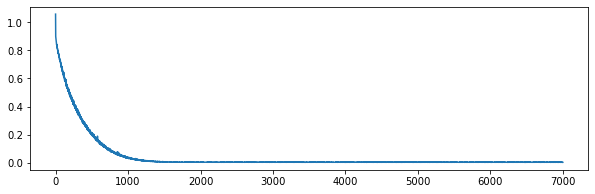

idx 4
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx1/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0014722778807144384 0.01355477761852911
std_all 0.03478933816582122 0.021755609534024993
mean_all -0.0001338118449809814 0.005754209070921782
std_all 0.025880403160778127 0.007722107373293516
mean_all 0.00040155139691749176 0.009159212541774375
std_all 0.028850048162459157 0.014668346639190595
[0.15502353 0.24312545 0.32234491 0.39895485 0.45838998 0.49463782
 0.52982315 0.5635152  0.59521253 0.62610458 0.65599627 0.68314013
 0.70912871 0.72615837 0.74272004 0.7578273  0.77216897 0.78582566
 0.79808182 0.8096122 ]
(81, 81)
[0.14782647 0.23572756 0.31963962 0.39896384 0.46355345 0.51015348
 0.55447567 0.59718709 0.63789495 0.67155076 0.70258053 0.73251616
 0.75975563 0.7774135  0.79371584 0.80950163 0.82459285 0.83716867
 0.84919134 0.86079588]
(81, 81)
[0.1495489  0.23480271 0.31700869 0.39632034 0.45894269 0.50115755
 0.54200908 0.58152358 0.618477   0.65256801

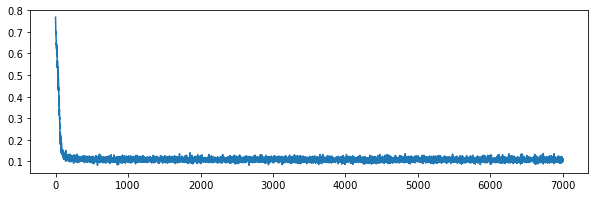

idx 5
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx1/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.002522006240436425 0.018434334421408943
std_all 0.01137466054714914 0.005465205845444663
mean_all -0.0005094676092010315 0.012318351444620715
std_all 0.010888293446605527 0.0047018909396314605
mean_all 0.0005010236740114539 0.014713200490120105
std_all 0.011050415813453398 0.004974660247040444
[0.46069021 0.49298173 0.51402296 0.53175316 0.54221332 0.55171008
 0.56054487 0.56863582 0.57633398 0.58392225 0.59142174 0.59881212
 0.60595741 0.61300794 0.61999083 0.62689371 0.63376032 0.64059256
 0.64739012 0.6541644 ]
(81, 81)
[0.4075489  0.42741825 0.44514534 0.46106457 0.47289719 0.48337957
 0.49340787 0.5026805  0.51155615 0.5202669  0.52862974 0.5367996
 0.54483496 0.55277723 0.5606328  0.56844982 0.57615826 0.58384093
 0.59146973 0.59901803]
(81, 81)
[0.42682206 0.45056423 0.46909848 0.48559459 0.49703471 0.50692346
 0.51660553 0.52541584 0.53381891 0.54197998 0

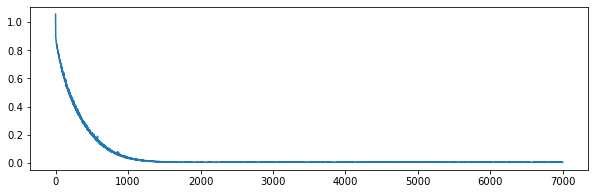

idx 6
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx1/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0011433782845249045 0.013263712326355398
std_all 0.032703815478761576 0.020371441860949434
mean_all -0.000149018704236618 0.005438499952192072
std_all 0.024536788447762168 0.007509510469873041
mean_all 0.0002817802920172228 0.008873070772236227
std_all 0.027259130791428637 0.013811203489740074
[0.15274323 0.24123999 0.32055301 0.39690736 0.45696117 0.49266763
 0.52788012 0.56145267 0.59317581 0.62424372 0.65420616 0.68133531
 0.70731174 0.72437943 0.74118685 0.7563164  0.77075117 0.78415537
 0.7962977  0.80783954]
(81, 81)
[0.14837124 0.23634727 0.32020668 0.39954656 0.46414807 0.51073666
 0.55503653 0.59777922 0.63840179 0.67202228 0.7030358  0.73290281
 0.76016101 0.77777788 0.79406929 0.80980322 0.82486713 0.83744604
 0.84945692 0.86103169]
(81, 81)
[0.14897989 0.23442498 0.31663718 0.39589665 0.45876251 0.50106752
 0.54190848 0.58143906 0.61833724 0.6522

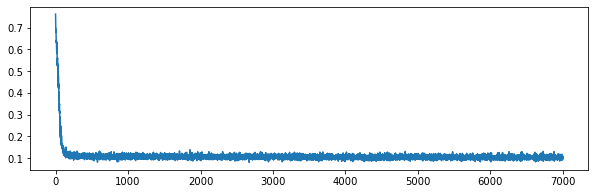

idx 7
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx1/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0005196203394970222 0.025733972857768368
std_all 0.01430198385459357 0.005942764333741444
mean_all -0.0018778176743567978 0.01590397968624566
std_all 0.012676128765520378 0.005116775024111678
mean_all -0.001078671669738858 0.019764802931689533
std_all 0.01321808046187811 0.0054602042412424355
[0.46510974 0.52823371 0.5691033  0.60562289 0.62594315 0.6454126
 0.66090722 0.67540109 0.68704672 0.69831699 0.70795222 0.71655459
 0.72469625 0.73264606 0.74040534 0.74776728 0.7548513  0.76150915
 0.76804481 0.77437414]
(81, 81)
[0.38641743 0.43406063 0.46925154 0.50273482 0.52641502 0.54886286
 0.56860925 0.58802806 0.60306198 0.61691753 0.63020465 0.6426895
 0.65503821 0.66696738 0.67684685 0.68657328 0.69586003 0.7048334
 0.71353557 0.72185003]
(81, 81)
[0.41429997 0.46640779 0.50279345 0.53679938 0.55893756 0.58037063
 0.59865123 0.61683839 0.63080801 0.64387771 

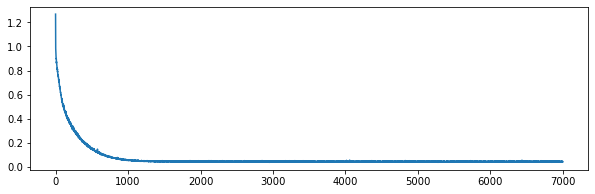

idx 8
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx2/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0005520325708660697 0.013241657144170286
std_all 0.03637999065287537 0.02522213489777786
mean_all -0.00026245956801662195 0.008295429848594882
std_all 0.03328833035737689 0.010002434962529895
mean_all 0.00014478650142472392 0.011056385915362796
std_all 0.034834160505126124 0.019248168428096284
[0.14034085 0.2156787  0.28919045 0.35894153 0.40912405 0.45314723
 0.49123964 0.52566146 0.55853993 0.58915353 0.6178712  0.64597139
 0.67338566 0.69271638 0.71159442 0.729746   0.74701285 0.76082436
 0.7741006  0.78603142]
(81, 81)
[0.16347164 0.25676717 0.34442485 0.42365059 0.48096157 0.53342654
 0.57133669 0.60737579 0.64228659 0.67057402 0.69871282 0.7254008
 0.75155687 0.76918783 0.7861122  0.80219764 0.81730316 0.8311301
 0.8425835  0.85363114]
(81, 81)
[0.15168687 0.23507678 0.31628594 0.39019115 0.44384792 0.49203003
 0.52933538 0.5651703  0.59898439 0.62775715 0

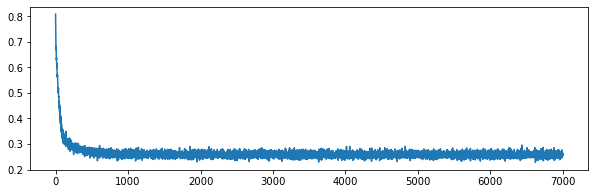

idx 9
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx2/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0015533504204516073 0.0173693433206147
std_all 0.015279135805951135 0.01668360143532807
mean_all -0.0011288821597033086 0.00880050336280402
std_all 0.01502017458415299 0.0114686890952689
mean_all 0.0002122341303741493 0.013833657011707525
std_all 0.015149655195052063 0.014316195669136726
[0.36345637 0.40080347 0.43275487 0.46176035 0.47979513 0.49689419
 0.51346493 0.52948262 0.54258003 0.55545821 0.56753587 0.57890235
 0.58960365 0.60008435 0.61035444 0.62005278 0.62935929 0.63828664
 0.64696022 0.65544857]
(81, 81)
[0.2325923  0.27375513 0.3056386  0.33493942 0.35729137 0.37803791
 0.39723765 0.41561467 0.43253595 0.44828343 0.46195728 0.47522207
 0.48833812 0.50045566 0.51228762 0.52393192 0.53534664 0.54627754
 0.55672425 0.56693215]
(81, 81)
[0.29960608 0.33873616 0.36912173 0.39766777 0.4177484  0.43643442
 0.4549046  0.47303074 0.48764932 0.50191704 0.5151

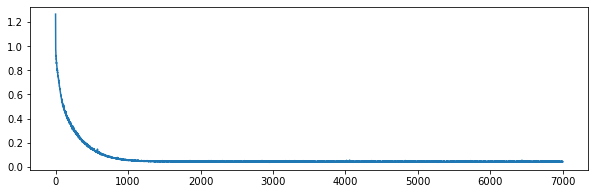

idx 10
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx2/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0005249209004660116 0.012889405212435883
std_all 0.035921138374117284 0.024665298698408573
mean_all -0.0002594778268252291 0.008214647765941073
std_all 0.03294142591999627 0.009872117499576701
mean_all 0.00013272153682039129 0.010814916673986397
std_all 0.03443128214705678 0.018845092291652307
[0.14042755 0.21583063 0.28936443 0.35931215 0.40948918 0.45351584
 0.49163542 0.52604544 0.5589121  0.58947496 0.61818675 0.6462775
 0.67368532 0.69298256 0.71186618 0.73000375 0.74726216 0.76107357
 0.77434415 0.78626451]
(81, 81)
[0.16352407 0.25683963 0.34452158 0.4237632  0.48107802 0.5335428
 0.57144627 0.60749071 0.64239225 0.67068089 0.69881942 0.72550634
 0.75165783 0.76928146 0.78619963 0.80228126 0.81738273 0.83120687
 0.84265484 0.85369989]
(81, 81)
[0.15176831 0.23518785 0.31642832 0.39044128 0.44409613 0.49227902
 0.52959445 0.56542284 0.59923087 0.62798

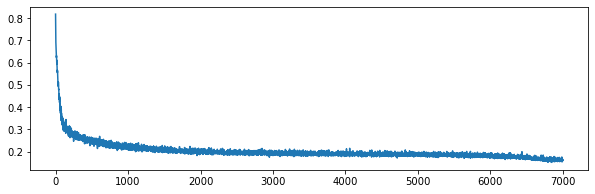

idx 11
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx2/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0002446072005692435 0.013501159006768213
std_all 0.0235917348236935 0.012119253208438222
mean_all -0.0010057275785018017 0.008480084798661833
std_all 0.02324474616136773 0.010688468128192036
mean_all -0.0003805601889662791 0.011291031867114963
std_all 0.023418240492530613 0.011427594887453535
[0.19066137 0.28608697 0.35060855 0.41346799 0.45992144 0.5023374
 0.5387763  0.56922685 0.59821142 0.62601168 0.65038821 0.67392865
 0.69691366 0.71875051 0.73407583 0.74921715 0.76416262 0.77859405
 0.7893835  0.7998459 ]
(81, 81)
[0.16441896 0.25147635 0.33495585 0.41514968 0.46760843 0.51510072
 0.55972817 0.59408683 0.625968   0.65178474 0.67746897 0.70246753
 0.72700754 0.74755295 0.76376723 0.77973225 0.79470221 0.8077283
 0.8202281  0.83067271]
(81, 81)
[0.17617013 0.26407123 0.33889864 0.41052478 0.45851198 0.50460279
 0.54627722 0.57784755 0.60758759 0.6358622

In [10]:
collect_all()